#################################################### Importing Libraries ####################################################

In [1]:
!pip install import_ipynb
!pip install -U -q PyDrive
!pip install pytorch_pretrained_bert
!pip install sparse
!pip install transformers
!pip install torchmetrics
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
2.1.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip

In [2]:
!pip install einops


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat

import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor

from sklearn.model_selection import ShuffleSplit
import pickle
from matplotlib import pyplot as plt
from tqdm import tqdm

#################################################### Importing Data ####################################################

In [4]:
#######################################################################################################################################

'''
chemin = "../Tests_donnees/"

# ouvrir un fichier pickle en mode lecture
with open(chemin + "dic_global_reverse.pkl", "rb") as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    dic = mon_depickler.load()
    
#print(dic.keys())

nb_nodes = len(dic)+5
print(nb_nodes)
'''
#######################################################################################################################################

9404


#################################################### Defining classes ####################################################

In [2]:
#######################################################################################################################################
###################################################### Transformer Conv ###############################################################
#######################################################################################################################################

class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [3]:
#######################################################################################################################################
###################################################### Graph Transformer ###############################################################
#######################################################################################################################################

class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)
        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5) 
        self.embed_ee = nn.Embedding(8, config.hidden_size // 5)
                    

    def forward(self, x, edge_index, edge_index_readout, edge_attr, batch):
        #print("GT")
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x, h_nodes

In [4]:
#######################################################################################################################################
######################################################## Bert Config ##################################################################
#######################################################################################################################################

class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')

In [5]:
class Pre_training_1(nn.Module):
    def __init__(self, config):
        super(Pre_training_1, self).__init__()
        self.config = config
        self.gnn = GraphTransformer(config)
        self.linear = nn.Linear(self.config.hidden_size // 5, self.config.vocab_size)
        self.layers = nn.ModuleList([self.gnn, self.linear])

    def forward(self, nodes, edge_index, edge_index_readout, edge_attr, batch):
        # Define the forward pass using self.gnn and self.linear as needed
        vst,x = self.gnn(nodes, edge_index, edge_index_readout, edge_attr, batch)
        x = self.linear(x)
        return x

In [6]:
#######################################################################################################################################
############################################################ GDSet ####################################################################
#######################################################################################################################################

class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

#################################################### Importing Data ######################################################

In [7]:
import pickle
with open('../../data/data_pad.pkl', 'rb') as handle:
    dataset = pickle.load(handle)

##################################################### Splitting Data ######################################################

In [ ]:
rr=1

#######################################################################################################################################
k = 5

#######################################################################################################################################
pourcentage_nodes_to_mask = 0.15
labels_masked_nodes = []
mask_node_embeddings = 2

In [ ]:
train_l = int(len(dataset)*0.70)
val_l = int(len(dataset)*0.10)
test_l = len(dataset) - val_l - train_l
number_output = 1

In [ ]:
rs = ShuffleSplit(n_splits=1, test_size=.20, random_state=rr)


for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
  rs2 = ShuffleSplit(n_splits=1, test_size=.125, random_state=rr)
  for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
    train_index = train_index_tmp[train_index]

    trainDSet = [dataset[x] for x in train_index]
    valDSet = [dataset[x] for x in val_index]
    testDSet = [dataset[x] for x in test_index]

###################################################### Config Files ######################################################

In [ ]:
file_config = {
    'model_path': 'model/', # where to save model
    'model_name': 'CVDTransformer', # model name
    'file_name': 'log.txt',  # log path
}
#create_folder(file_config['model_path'])

global_params = {
    'max_seq_len': 50,
    'month': 1,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 0.001,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 5,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"),
    'data_len' : len(dataset),
    'train_data_len' : train_l,
    'val_data_len' : val_l,
    'test_data_len' : test_l,
    'epochs' : 50,
    'action' : 'train'
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding (avec vst) + 1 for mask
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11, # number of vocab for type embedding
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'gender_vocab_size': 2,
    'ethnicity_vocab_size': 2,
    'race_vocab_size': 6,
    'num_labels':1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'number_output' : 1,
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

######################################################## CUDA ##########################################################

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# print which device is used
print('device: ', train_params['device'])

device:  cuda


#################################################### Creating Model ####################################################

In [ ]:
conf = BertConfig(model_config)
model = Pre_training_1(conf).to(train_params['device'])
vars = [i for i in model.parameters()]

optim = torch.optim.AdamW(vars, lr=optim_param['lr'])
CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)

#################################################### Training Functions ####################################################

In [ ]:
print(len(vars))
print(type(vars))
print(vars[-1].shape)

55
<class 'list'>
torch.Size([9405])


In [113]:
def train(trainload, device, config, ignore = False):
    tr_loss = 0
    start = time.time()
    model.train()
    for step, data in tqdm(enumerate(trainload)):
        optim.zero_grad()

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
                
        list_index = [i for i in range(nodes.shape[0])]
        random.shuffle(list_index)
        index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
        index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
        labels_nodes = nodes
        ytrue = nodes
        if ignore:
            labels_nodes[index_nodes_not_masked] = 3
        nodes[index_nodes_to_mask] = mask_node_embeddings
        
        edge_index = graph_batch.edge_index
        edge_index_readout = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch
        attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
        attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)

        pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)

        # couche lineaire pour predire les labels des noeuds masqués
        
        loss = CE_loss(pred, labels_nodes)
        loss.backward()
        tr_loss += loss.item()
        optim.step()

        #sched.step()
        del loss
        #result = result + torch.sum(torch.sum(torch.mul(torch.abs(torch.subtract(pred, label)), target_mask), dim = 0)).cpu()
        #sum_labels = sum_labels + torch.sum(target_mask, dim=0).cpu()
    #print(result / sum_labels)
    print("TOTAL TRAIN LOSS", (tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    return tr_loss, cost, pred,ytrue

In [114]:
def eval(_valload, saving, device, config, ignore = False):
    tr_loss = 0
    start = time.time()
    model.eval()
    with torch.no_grad():
        for step, data in tqdm(enumerate(_valload)):
            optim.zero_grad()

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
                    
            list_index = [i for i in range(nodes.shape[0])]
            random.shuffle(list_index)
            index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
            index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
            labels_nodes = nodes
            ytrue = nodes
            if ignore:
                labels_nodes[index_nodes_not_masked] = 3
            nodes[index_nodes_to_mask] = mask_node_embeddings
            
            edge_index = graph_batch.edge_index
            edge_index_readout = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)

            pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)

            # couche lineaire pour predire les labels des noeuds masqués

            loss = CE_loss(pred, labels_nodes)
            tr_loss += loss.item()
            
            del loss

    print("TOTAL EVAL LOSS", (tr_loss * train_params['batch_size']) / len(_valload))

    cost = time.time() - start
    return tr_loss, cost, pred, ytrue

In [115]:
def run_epoch(trainload, valload, device):
    with open("v_behrt_log_train.txt", 'w') as f:
            f.write('')
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []
    for e in tqdm(range(train_params["epochs"])):
        print("Epoch n" + str(e))
        train_loss, train_time_cost, pred_train, ytrue_train = train(trainload, device, config=model_config)
        val_loss, val_time_cost, pred_eval, ytrue_eval = eval(valload, False, device, config=model_config)
        accuracy_train = skm.accuracy_score(ytrue_train.cpu().detach().numpy(), pred_train.cpu().detach().numpy().argmax(axis=1))
        accuracy_eval = skm.accuracy_score(ytrue_eval.cpu().detach().numpy(), pred_eval.cpu().detach().numpy().argmax(axis=1))

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        print('TRAIN \t{} secs'.format(train_time_cost))
        print(f'TRAIN accuracy : {accuracy_train}')
        with open("../../data/pre_training_1_log_train.txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')
        print('EVAL \t{} secs'.format(val_time_cost))
        print('EVAL accuracy : {}\n\n'.format(accuracy_eval))
        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            torch.save(model.gnn.state_dict(), '../../data/'+'GraphTransformer_pretrain_1' + '.pch')
            best_val = val_loss
    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('../../data/Pre_training_1.png')
    plt.show()

    return train_loss, val_loss, accuracy_train, accuracy_eval

################################################### Evaluation Functions ####################################################

######################################################## Saving #########################################################

##################################################### Training loop ######################################################

50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch n0


859it [01:01, 13.96it/s]


TOTAL TRAIN LOSS 4.110503793608427


123it [00:05, 24.04it/s]
  2%|▏         | 1/50 [01:06<54:28, 66.69s/it]

TOTAL EVAL LOSS 0.29940734867279123
TRAIN 	61.53803730010986 secs
TRAIN accuracy : 0.9829545454545454
EVAL 	5.12227463722229 secs
EVAL accuracy : 0.9860627177700348


** ** * Saving fine - tuned model ** ** * 
Epoch n1


859it [01:02, 13.81it/s]


TOTAL TRAIN LOSS 0.3562289224265358


123it [00:05, 23.79it/s]
  4%|▍         | 2/50 [02:14<53:42, 67.13s/it]

TOTAL EVAL LOSS 0.12969074131470415
TRAIN 	62.222342014312744 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	5.175351142883301 secs
EVAL accuracy : 0.9930313588850174


** ** * Saving fine - tuned model ** ** * 
Epoch n2


859it [01:06, 12.91it/s]


TOTAL TRAIN LOSS 0.16576869583339565


123it [00:04, 25.09it/s]
  6%|▌         | 3/50 [03:25<54:08, 69.13s/it]

TOTAL EVAL LOSS 0.0904149576338132
TRAIN 	66.55257987976074 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	4.909373044967651 secs
EVAL accuracy : 0.9941927990708479


** ** * Saving fine - tuned model ** ** * 
Epoch n3


859it [01:03, 13.58it/s]


TOTAL TRAIN LOSS 0.10192274975880972


123it [00:05, 23.87it/s]
  8%|▊         | 4/50 [04:34<52:47, 68.87s/it]

TOTAL EVAL LOSS 0.06970071209297003
TRAIN 	63.275622844696045 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	5.159395456314087 secs
EVAL accuracy : 0.9965156794425087


** ** * Saving fine - tuned model ** ** * 
Epoch n4


859it [01:03, 13.56it/s]


TOTAL TRAIN LOSS 0.0666289603068901


123it [00:04, 24.62it/s]
 10%|█         | 5/50 [05:42<51:31, 68.70s/it]

TOTAL EVAL LOSS 0.06402286369615379
TRAIN 	63.36903786659241 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	5.003401756286621 secs
EVAL accuracy : 0.9965156794425087


** ** * Saving fine - tuned model ** ** * 
Epoch n5


859it [01:02, 13.72it/s]


TOTAL TRAIN LOSS 0.04584231113409732


123it [00:04, 25.18it/s]
 12%|█▏        | 6/50 [06:50<50:05, 68.31s/it]

TOTAL EVAL LOSS 0.062411248298736254
TRAIN 	62.621663093566895 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	4.892164945602417 secs
EVAL accuracy : 0.9988385598141696


** ** * Saving fine - tuned model ** ** * 
Epoch n6


859it [01:03, 13.57it/s]


TOTAL TRAIN LOSS 0.034442542978208424


123it [00:05, 21.95it/s]
 14%|█▍        | 7/50 [07:59<49:06, 68.52s/it]

TOTAL EVAL LOSS 0.05931900527985167
TRAIN 	63.29973888397217 secs
TRAIN accuracy : 1.0
EVAL 	5.610600471496582 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n7


859it [01:09, 12.34it/s]


TOTAL TRAIN LOSS 0.024611982705153697


123it [00:05, 20.75it/s]
 16%|█▌        | 8/50 [09:14<49:32, 70.78s/it]

TOTAL EVAL LOSS 0.06296911466784781
TRAIN 	69.64620041847229 secs
TRAIN accuracy : 1.0
EVAL 	5.934920072555542 secs
EVAL accuracy : 1.0


Epoch n8


859it [01:07, 12.70it/s]


TOTAL TRAIN LOSS 0.01835761915754331


123it [00:04, 24.70it/s]
 18%|█▊        | 9/50 [10:27<48:46, 71.37s/it]

TOTAL EVAL LOSS 0.05730725137291893
TRAIN 	67.63521599769592 secs
TRAIN accuracy : 0.9943181818181818
EVAL 	4.987590551376343 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n9


859it [01:02, 13.79it/s]


TOTAL TRAIN LOSS 0.014143189853688808


123it [00:04, 24.92it/s]
 20%|██        | 10/50 [11:34<46:44, 70.10s/it]

TOTAL EVAL LOSS 0.056437270196137826
TRAIN 	62.29473567008972 secs
TRAIN accuracy : 1.0
EVAL 	4.943136215209961 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n10


859it [01:02, 13.73it/s]


TOTAL TRAIN LOSS 0.010951037064089444


123it [00:04, 24.69it/s]
 22%|██▏       | 11/50 [12:42<45:03, 69.33s/it]

TOTAL EVAL LOSS 0.06028265174210478
TRAIN 	62.558815479278564 secs
TRAIN accuracy : 1.0
EVAL 	4.988528251647949 secs
EVAL accuracy : 1.0


Epoch n11


859it [01:02, 13.65it/s]


TOTAL TRAIN LOSS 0.008893262439161635


123it [00:04, 25.07it/s]
 24%|██▍       | 12/50 [13:50<43:37, 68.89s/it]

TOTAL EVAL LOSS 0.058083100788754644
TRAIN 	62.94296932220459 secs
TRAIN accuracy : 1.0
EVAL 	4.913257598876953 secs
EVAL accuracy : 1.0


Epoch n12


859it [01:10, 12.10it/s]


TOTAL TRAIN LOSS 0.007029384734409976


123it [00:05, 23.66it/s]
 26%|██▌       | 13/50 [15:06<43:50, 71.10s/it]

TOTAL EVAL LOSS 0.061063268778842786
TRAIN 	70.97821688652039 secs
TRAIN accuracy : 1.0
EVAL 	5.206210136413574 secs
EVAL accuracy : 1.0


Epoch n13


859it [01:04, 13.40it/s]


TOTAL TRAIN LOSS 0.006113683834591811


123it [00:05, 23.99it/s]
 28%|██▊       | 14/50 [16:15<42:19, 70.55s/it]

TOTAL EVAL LOSS 0.06156545572004695
TRAIN 	64.12649178504944 secs
TRAIN accuracy : 1.0
EVAL 	5.13383150100708 secs
EVAL accuracy : 1.0


Epoch n14


859it [01:03, 13.53it/s]


TOTAL TRAIN LOSS 0.004753672224053424


123it [00:05, 24.15it/s]
 30%|███       | 15/50 [17:24<40:48, 69.96s/it]

TOTAL EVAL LOSS 0.061970704846668175
TRAIN 	63.47498679161072 secs
TRAIN accuracy : 1.0
EVAL 	5.098595857620239 secs
EVAL accuracy : 1.0


Epoch n15


859it [01:02, 13.82it/s]


TOTAL TRAIN LOSS 0.0041931887642887074


123it [00:05, 23.78it/s]
 32%|███▏      | 16/50 [18:31<39:11, 69.18s/it]

TOTAL EVAL LOSS 0.05975067199769207
TRAIN 	62.147913694381714 secs
TRAIN accuracy : 1.0
EVAL 	5.178412437438965 secs
EVAL accuracy : 1.0


Epoch n16


859it [01:01, 13.99it/s]


TOTAL TRAIN LOSS 0.0035018915117714586


123it [00:05, 24.45it/s]
 34%|███▍      | 17/50 [19:37<37:35, 68.36s/it]

TOTAL EVAL LOSS 0.06201556022982852
TRAIN 	61.38628315925598 secs
TRAIN accuracy : 1.0
EVAL 	5.036789178848267 secs
EVAL accuracy : 1.0


Epoch n17


859it [01:02, 13.85it/s]


TOTAL TRAIN LOSS 0.0033683101223321837


123it [00:04, 24.73it/s]
 36%|███▌      | 18/50 [20:44<36:14, 67.96s/it]

TOTAL EVAL LOSS 0.057011230731867396
TRAIN 	62.04664969444275 secs
TRAIN accuracy : 1.0
EVAL 	4.979593515396118 secs
EVAL accuracy : 1.0


Epoch n18


859it [01:02, 13.68it/s]


TOTAL TRAIN LOSS 0.002948260432675745


123it [00:04, 24.81it/s]
 38%|███▊      | 19/50 [21:52<35:05, 67.91s/it]

TOTAL EVAL LOSS 0.05661588425528519
TRAIN 	62.81345462799072 secs
TRAIN accuracy : 1.0
EVAL 	4.963712692260742 secs
EVAL accuracy : 1.0


Epoch n19


859it [01:02, 13.67it/s]


TOTAL TRAIN LOSS 0.002552423384745913


123it [00:05, 24.55it/s]
 40%|████      | 20/50 [23:00<33:57, 67.90s/it]

TOTAL EVAL LOSS 0.056761691691449165
TRAIN 	62.833051919937134 secs
TRAIN accuracy : 1.0
EVAL 	5.015593767166138 secs
EVAL accuracy : 1.0


Epoch n20


859it [01:01, 13.98it/s]


TOTAL TRAIN LOSS 0.002448470657727782


123it [00:05, 23.83it/s]
 42%|████▏     | 21/50 [24:07<32:38, 67.52s/it]

TOTAL EVAL LOSS 0.05785655764410424
TRAIN 	61.447489976882935 secs
TRAIN accuracy : 1.0
EVAL 	5.16826605796814 secs
EVAL accuracy : 1.0


Epoch n21


859it [01:01, 13.85it/s]


TOTAL TRAIN LOSS 0.001846807753772885


123it [00:05, 24.44it/s]
 44%|████▍     | 22/50 [25:14<31:26, 67.38s/it]

TOTAL EVAL LOSS 0.058301385326987996
TRAIN 	62.005993604660034 secs
TRAIN accuracy : 1.0
EVAL 	5.038191080093384 secs
EVAL accuracy : 1.0


Epoch n22


859it [01:02, 13.81it/s]


TOTAL TRAIN LOSS 0.0017192477229171842


123it [00:05, 24.14it/s]
 46%|████▌     | 23/50 [26:21<30:19, 67.38s/it]

TOTAL EVAL LOSS 0.053339102869121906
TRAIN 	62.22754192352295 secs
TRAIN accuracy : 1.0
EVAL 	5.100606203079224 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n23


859it [01:02, 13.75it/s]


TOTAL TRAIN LOSS 0.001738956706920974


123it [00:04, 24.68it/s]
 48%|████▊     | 24/50 [27:29<29:12, 67.42s/it]

TOTAL EVAL LOSS 0.05963741970463275
TRAIN 	62.493074893951416 secs
TRAIN accuracy : 1.0
EVAL 	4.9902966022491455 secs
EVAL accuracy : 1.0


Epoch n24


859it [01:03, 13.51it/s]


TOTAL TRAIN LOSS 0.0015529743514848269


123it [00:05, 24.51it/s]
 50%|█████     | 25/50 [28:37<28:14, 67.78s/it]

TOTAL EVAL LOSS 0.05973222039054531
TRAIN 	63.566367387771606 secs
TRAIN accuracy : 1.0
EVAL 	5.0248613357543945 secs
EVAL accuracy : 1.0


Epoch n25


859it [01:02, 13.82it/s]


TOTAL TRAIN LOSS 0.0013750474856163038


123it [00:05, 24.36it/s]
 52%|█████▏    | 26/50 [29:45<27:02, 67.62s/it]

TOTAL EVAL LOSS 0.05666421377620451
TRAIN 	62.17823338508606 secs
TRAIN accuracy : 1.0
EVAL 	5.055874824523926 secs
EVAL accuracy : 1.0


Epoch n26


859it [01:01, 14.00it/s]


TOTAL TRAIN LOSS 0.001289450151605757


123it [00:05, 24.47it/s]
 54%|█████▍    | 27/50 [30:51<25:46, 67.26s/it]

TOTAL EVAL LOSS 0.05616558461576729
TRAIN 	61.36854362487793 secs
TRAIN accuracy : 1.0
EVAL 	5.032581806182861 secs
EVAL accuracy : 1.0


Epoch n27


859it [01:02, 13.73it/s]


TOTAL TRAIN LOSS 0.0012717375341716717


123it [00:05, 24.13it/s]
 56%|█████▌    | 28/50 [31:59<24:42, 67.39s/it]

TOTAL EVAL LOSS 0.0584392406312128
TRAIN 	62.574328899383545 secs
TRAIN accuracy : 1.0
EVAL 	5.1032867431640625 secs
EVAL accuracy : 1.0


Epoch n28


859it [01:03, 13.55it/s]


TOTAL TRAIN LOSS 0.0009500712067710569


123it [00:05, 22.19it/s]
 58%|█████▊    | 29/50 [33:08<23:45, 67.87s/it]

TOTAL EVAL LOSS 0.055742596564401704
TRAIN 	63.403419971466064 secs
TRAIN accuracy : 1.0
EVAL 	5.550711154937744 secs
EVAL accuracy : 1.0


Epoch n29


859it [01:03, 13.62it/s]


TOTAL TRAIN LOSS 0.001027992120521869


123it [00:04, 25.04it/s]
 60%|██████    | 30/50 [34:16<22:38, 67.91s/it]

TOTAL EVAL LOSS 0.05499346302161202
TRAIN 	63.07392716407776 secs
TRAIN accuracy : 1.0
EVAL 	4.918335437774658 secs
EVAL accuracy : 1.0


Epoch n30


859it [01:01, 13.91it/s]


TOTAL TRAIN LOSS 0.0008143017578343242


123it [00:05, 24.26it/s]
 62%|██████▏   | 31/50 [35:23<21:24, 67.60s/it]

TOTAL EVAL LOSS 0.05310089162271864
TRAIN 	61.75060176849365 secs
TRAIN accuracy : 1.0
EVAL 	5.076120853424072 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n31


859it [01:01, 13.90it/s]


TOTAL TRAIN LOSS 0.0009013587517249712


123it [00:05, 23.57it/s]
 64%|██████▍   | 32/50 [36:30<20:13, 67.44s/it]

TOTAL EVAL LOSS 0.053382051999543836
TRAIN 	61.81974911689758 secs
TRAIN accuracy : 1.0
EVAL 	5.225281476974487 secs
EVAL accuracy : 1.0


Epoch n32


859it [01:02, 13.67it/s]


TOTAL TRAIN LOSS 0.0008845006936452432


123it [00:05, 23.64it/s]
 66%|██████▌   | 33/50 [37:38<19:09, 67.64s/it]

TOTAL EVAL LOSS 0.05305295102477332
TRAIN 	62.864394187927246 secs
TRAIN accuracy : 1.0
EVAL 	5.209970712661743 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n33


859it [01:04, 13.37it/s]


TOTAL TRAIN LOSS 0.0006220713593460919


123it [00:05, 23.96it/s]
 68%|██████▊   | 34/50 [38:47<18:10, 68.17s/it]

TOTAL EVAL LOSS 0.05715916582861368
TRAIN 	64.24705648422241 secs
TRAIN accuracy : 1.0
EVAL 	5.139719486236572 secs
EVAL accuracy : 1.0


Epoch n34


859it [01:02, 13.76it/s]


TOTAL TRAIN LOSS 0.0006603911930071794


123it [00:05, 23.79it/s]
 70%|███████   | 35/50 [39:55<17:00, 68.02s/it]

TOTAL EVAL LOSS 0.053900210914330005
TRAIN 	62.44996428489685 secs
TRAIN accuracy : 1.0
EVAL 	5.176343679428101 secs
EVAL accuracy : 1.0


Epoch n35


859it [01:04, 13.34it/s]


TOTAL TRAIN LOSS 0.0006404563040467468


123it [00:05, 22.46it/s]
 72%|███████▏  | 36/50 [41:05<16:00, 68.58s/it]

TOTAL EVAL LOSS 0.054123286670746326
TRAIN 	64.3985104560852 secs
TRAIN accuracy : 1.0
EVAL 	5.483633041381836 secs
EVAL accuracy : 1.0


Epoch n36


859it [01:03, 13.56it/s]


TOTAL TRAIN LOSS 0.0006647231840259028


123it [00:05, 23.61it/s]
 74%|███████▍  | 37/50 [42:13<14:51, 68.59s/it]

TOTAL EVAL LOSS 0.05553197496698202
TRAIN 	63.36125087738037 secs
TRAIN accuracy : 1.0
EVAL 	5.216249227523804 secs
EVAL accuracy : 1.0


Epoch n37


859it [01:01, 13.90it/s]


TOTAL TRAIN LOSS 0.000572344571892499


123it [00:05, 23.82it/s]
 76%|███████▌  | 38/50 [43:20<13:37, 68.11s/it]

TOTAL EVAL LOSS 0.05334858354137798
TRAIN 	61.7860894203186 secs
TRAIN accuracy : 1.0
EVAL 	5.1694183349609375 secs
EVAL accuracy : 1.0


Epoch n38


859it [01:01, 13.90it/s]


TOTAL TRAIN LOSS 0.0006009671046444091


123it [00:05, 24.39it/s]
 78%|███████▊  | 39/50 [44:27<12:25, 67.74s/it]

TOTAL EVAL LOSS 0.05265416480163296
TRAIN 	61.79532194137573 secs
TRAIN accuracy : 1.0
EVAL 	5.049142360687256 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n39


859it [01:01, 13.86it/s]


TOTAL TRAIN LOSS 0.0004952394144981731


123it [00:05, 23.74it/s]
 80%|████████  | 40/50 [45:34<11:15, 67.58s/it]

TOTAL EVAL LOSS 0.051245039823326725
TRAIN 	61.987708568573 secs
TRAIN accuracy : 1.0
EVAL 	5.187349081039429 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n40


859it [01:02, 13.65it/s]


TOTAL TRAIN LOSS 0.0004986480126647243


123it [00:04, 24.91it/s]
 82%|████████▏ | 41/50 [46:42<10:09, 67.68s/it]

TOTAL EVAL LOSS 0.051604759870906444
TRAIN 	62.94887852668762 secs
TRAIN accuracy : 1.0
EVAL 	4.943086385726929 secs
EVAL accuracy : 1.0


Epoch n41


859it [01:02, 13.64it/s]


TOTAL TRAIN LOSS 0.0004319362489463639


123it [00:05, 23.28it/s]
 84%|████████▍ | 42/50 [47:51<09:02, 67.86s/it]

TOTAL EVAL LOSS 0.05144140487286881
TRAIN 	62.96522498130798 secs
TRAIN accuracy : 1.0
EVAL 	5.290407657623291 secs
EVAL accuracy : 1.0


Epoch n42


859it [01:02, 13.78it/s]


TOTAL TRAIN LOSS 0.0003063619532648549


123it [00:05, 23.83it/s]
 86%|████████▌ | 43/50 [48:58<07:54, 67.77s/it]

TOTAL EVAL LOSS 0.050920549570267676
TRAIN 	62.32279419898987 secs
TRAIN accuracy : 1.0
EVAL 	5.1671812534332275 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n43


859it [01:01, 13.87it/s]


TOTAL TRAIN LOSS 0.0006063894155059464


123it [00:05, 23.90it/s]
 88%|████████▊ | 44/50 [50:05<06:45, 67.57s/it]

TOTAL EVAL LOSS 0.051843171053910495
TRAIN 	61.925840854644775 secs
TRAIN accuracy : 1.0
EVAL 	5.1530442237854 secs
EVAL accuracy : 1.0


Epoch n44


859it [01:01, 14.03it/s]


TOTAL TRAIN LOSS 0.00035002459799665994


123it [00:05, 24.40it/s]
 90%|█████████ | 45/50 [51:12<05:35, 67.20s/it]

TOTAL EVAL LOSS 0.04611362999404804
TRAIN 	61.25230574607849 secs
TRAIN accuracy : 1.0
EVAL 	5.048182487487793 secs
EVAL accuracy : 1.0


** ** * Saving fine - tuned model ** ** * 
Epoch n45


859it [01:01, 14.04it/s]


TOTAL TRAIN LOSS 0.000363942337690227


123it [00:05, 24.31it/s]
 92%|█████████▏| 46/50 [52:18<04:27, 66.92s/it]

TOTAL EVAL LOSS 0.0467670720309567
TRAIN 	61.17625641822815 secs
TRAIN accuracy : 1.0
EVAL 	5.067035436630249 secs
EVAL accuracy : 1.0


Epoch n46


859it [01:03, 13.46it/s]


TOTAL TRAIN LOSS 0.00037060744021762284


123it [00:05, 23.63it/s]
 94%|█████████▍| 47/50 [53:27<03:22, 67.56s/it]

TOTAL EVAL LOSS 0.051014257522212884
TRAIN 	63.814680337905884 secs
TRAIN accuracy : 1.0
EVAL 	5.211724758148193 secs
EVAL accuracy : 1.0


Epoch n47


859it [01:02, 13.72it/s]


TOTAL TRAIN LOSS 0.00045183635678760364


123it [00:05, 23.81it/s]
 96%|█████████▌| 48/50 [54:35<02:15, 67.64s/it]

TOTAL EVAL LOSS 0.04618906450961883
TRAIN 	62.625951528549194 secs
TRAIN accuracy : 1.0
EVAL 	5.172678709030151 secs
EVAL accuracy : 1.0


Epoch n48


859it [01:02, 13.73it/s]


TOTAL TRAIN LOSS 0.0003913467116614088


123it [00:05, 24.13it/s]
 98%|█████████▊| 49/50 [55:42<01:07, 67.66s/it]

TOTAL EVAL LOSS 0.048949248883680054
TRAIN 	62.58963918685913 secs
TRAIN accuracy : 1.0
EVAL 	5.102696180343628 secs
EVAL accuracy : 1.0


Epoch n49


859it [01:02, 13.66it/s]


TOTAL TRAIN LOSS 0.00030724444914028413


123it [00:04, 24.82it/s]
100%|██████████| 50/50 [56:50<00:00, 68.21s/it]


TOTAL EVAL LOSS 0.04830498974313387
TRAIN 	62.868144273757935 secs
TRAIN accuracy : 1.0
EVAL 	4.960748910903931 secs
EVAL accuracy : 1.0




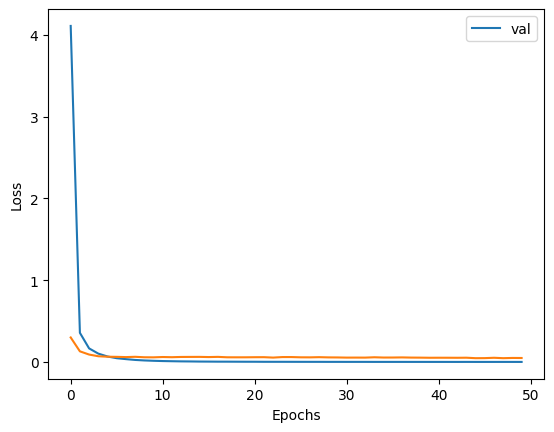

In [116]:
print(train_params['max_len_seq'])
if train_params['action'] == 'train' or train_params['action'] == 'resume':
    trainload = GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False)
    valload = GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)

    train_loss, val_loss, accuracy_train, accuracy_eval = run_epoch(trainload, valload, train_params['device'])

In [117]:
#Pour charger les parametre dans un nouveau modele:
#new_gnn = GraphTransformer(conf)  # Créez une nouvelle instance de GraphTransformer
#new_gnn.load_state_dict(torch.load('../../data/'+'GraphTransformer_pretrain_1' + '.pch'))